
# Deep Learning Homework 6 (Spring 2021)

This code is provided for Deep Learning class (CS 482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu. Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, and Keith Harrigian.


### Imports

In [1]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [3]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt
import gc

# Problem 1: Unsupervised Pre-training

### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

In [ ]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200

### Data Paths

In [ ]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "/content/gdrive/MyDrive/HW6Q1_data"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [ ]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader

##TODO: Add support for colorization dataset
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        # 0, 32, 64, 96, 128, 224
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """
        
        """
        ## Load Image and Parse Properties
        img_name = str(idx) + '_input.jpg'
        mask_name = str(idx) + '_mask.png'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        # h, w = mask.shape
        h, w = mask.shape[0], mask.shape[1]
        # print(h, w)

        ## Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            #if the mask has 3 dimension use this code
            new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
            #if the mask has 1 dimension use the code below
            #new_mask[:, :, idx] = mask == self.mask_value[idx]
        ## Transform image and mask
        if self.transform:
            img, mask = self.img_transform(img, new_mask)
        ## Use dictionary to output
        # sample = {'img': img, 'mask': mask}
        # return sample
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """
        
        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

### Model Architecture

Finish building the U-net architecture below.

In [ ]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        # super(UNET, self).__init__(n_classes)
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        # From 32 channels to 6 potential classes...
        self.last = nn.Sequential(
            nn.Conv2d(32, 6, kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        out = self.last(conv1m_out)
        return out

### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [ ]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    # assert img.shape[0] == 1 #This line can not be deleted
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    # prediction, torch.Size([256, 320])
    # target, torch.Size([6, 256, 320]), one-hot encoding 
    # 6 classes: 0, 32, 64, 96, 128, 224
    smooth = 1
    size = prediction.size(0) * prediction.size(1)
    pred = prediction
    pred_flat = pred.view(-1, size)
    if torch.cuda.is_available():
      # torch.cuda.empty_cache()
      pred_flat = pred_flat.cpu()
    pred_flat = pred_flat.detach().numpy()
    dice_classes = np.zeros(n_classes)
    for cl in range(n_classes):
        cls = target[cl]
        cls_flat = cls.view(-1, size)
        if torch.cuda.is_available():
          cls_flat = cls_flat.cpu()
        cls_flat = cls_flat.detach().numpy()
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        for i in range(size):
          if cls_flat[0][i] == 1 and pred_flat[0][i] == cl:
            TP += 1
          elif cls_flat[0][i] == 0 and pred_flat[0][i] == cl:
            FP += 1
          elif cls_flat[0][i] == 1 and pred_flat[0][i] != cl:
            FN += 1
          else:
            TN += 1
        #When there is no grount truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0, 
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        if (TP + FN == 0):
          if FP == 0:
            dice_classes[cl] = 1
          else:
            dice_classes[cl] = 0
        else:
          dice_classes[cl] = 2 * TP / (2 * TP + FP + FN) 
    return dice_classes.mean()


def dice_score_dataset(model, dataloader, num_classes, use_gpu=False):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        batch_size = prediction.shape[0]
        for i in range(batch_size):
          scores[idx] += dice_score_image(prediction[i], target[i], n_classes)
        scores[idx] /= batch_size
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


class BinaryDICELoss(nn.Module):
    def __init__(self):
      super(BinaryDICELoss, self).__init__()
      
    def forward(self, pred, target):
      # pred: (N H W)
      # target: (N H W)
      smooth = 1
      batch_size = target.shape[0]
      loss = 0
      pred_flat = pred.view(batch_size, -1)
      target_flat = target.view(batch_size, -1)
      dice_score = (2 * ((pred_flat * target_flat).sum()) + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
      loss = (1 - dice_score) / batch_size
      return loss


# TODO: Implement DICE loss, 
# It should conform to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self):
      super(DICELoss, self).__init__()
      
    def forward(self, pred, target):
      # pred: (N C H W)
      # target: (N C H W), one-hot already
      smooth = 1
      batch_size = target.shape[0]
      n_classes = target.shape[1]
      criterion = BinaryDICELoss()
      loss = 0
      for i in range(n_classes):
        # print(pred[:,i].shape)
        # pred, target from (N C H W) into (N H W)
        loss += criterion(pred[:,i], target[:,i])
      loss /= n_classes
      return loss

## (a) Training Procedure (Segmentation)




In [ ]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)
if torch.cuda.is_available():
    model.cuda()
criterion = DICELoss()

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

print("Start Training...")
train_losses = []
train_epoch = []
val_losses = []
val_epoch = []
test_scores = []
num_epochs = 200
# Epoch Begins
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    model.train()
    for i, (inputs, targets) in enumerate(train_dataloader):
      if torch.cuda.is_available():
        inputs = inputs.cuda()
        targets = targets.cuda()
      if i == 0:
        inputs1 = inputs
        targets1 = targets
      outputs = model(inputs)
      train_loss = criterion(model(inputs), targets)
      train_losses.append(train_loss.item())
      train_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    train_loss_avg = np.mean(train_losses[-30:])
    train_epoch.append(train_loss_avg)
    print("train loss:", train_loss_avg)
    scheduler.step()
    ########################### Validation #####################################
    # TODO: Design your own validation section
    # model.eval()
    for i, (inputs, targets) in enumerate(validation_dataloader):
      if torch.cuda.is_available():
        torch.cuda.empty_cache()
        inputs = inputs.cuda()
        targets = targets.cuda()
      outputs = model(inputs)
      val_loss = criterion(model(inputs), targets)
      val_losses.append(val_loss.item())
    val_loss_avg = np.mean(val_losses[-5:])
    val_epoch.append(val_loss_avg)
    print("val loss:", val_loss_avg)
# Epoch Ends
print("\nTraining Finished.")

Start Training...

EPOCH 1 of 200

train loss: 0.08313504498869684
val loss: 0.0808051286030004

EPOCH 2 of 200

train loss: 0.08182105595087796
val loss: 0.0799176440187029

EPOCH 3 of 200

train loss: 0.08073185895365416
val loss: 0.07897982603959473

EPOCH 4 of 200

train loss: 0.07975080667700223
val loss: 0.0780575268803606

EPOCH 5 of 200

train loss: 0.07880819571986487
val loss: 0.07715303551636818

EPOCH 6 of 200

train loss: 0.07790836042688197
val loss: 0.07629263872268117

EPOCH 7 of 200

train loss: 0.07702630435139801
val loss: 0.07544539559955209

EPOCH 8 of 200

train loss: 0.07616843177661947
val loss: 0.07463126366618543

EPOCH 9 of 200

train loss: 0.07537342873483592
val loss: 0.07387516040726001

EPOCH 10 of 200

train loss: 0.07462230371211429
val loss: 0.07317154694470741

EPOCH 11 of 200

train loss: 0.07301459167446894
val loss: 0.07171728325333467

EPOCH 12 of 200

train loss: 0.0716233572625807
val loss: 0.07045060666117575

EPOCH 13 of 200

train loss: 0.070

test score: 0.52121448429599


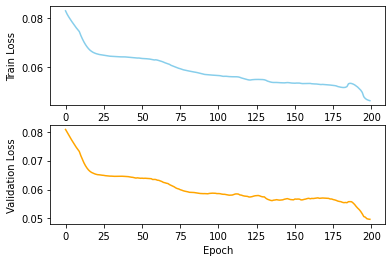

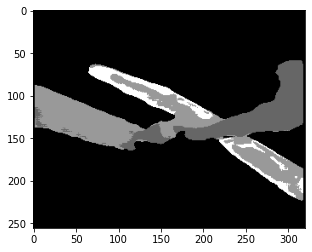

In [ ]:
########################### Testing #####################################
if torch.cuda.is_available():
  torch.cuda.empty_cache()
test_scores.append(dice_score_dataset(model, test_dataloader, n_classes, True))
print("test score:", test_scores[-1])
########################### Plotting #####################################
# Plot train/val loss w.r.t. epoch
plt.subplot(211)
plt.plot(train_epoch, 'skyblue')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.subplot(212)
plt.plot(val_epoch, 'orange')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()

# Plotting one image as an example
torch.cuda.empty_cache()
outputs1 = model(inputs1)
preds1 = torch.argmax(outputs1, dim=1)
pic = 32 * preds1[0] / 255
pic = pic.cpu()
pic = pic.numpy()
# print(pic.shape)
plt.imshow(pic, cmap=plt.cm.gray)
plt.show()

## Data Augmentation (Off line)


In [ ]:
# import os
# from PIL import Image

# size = 300
# # Left Right Flip
# for i in range(size):
#     input_path = "HW6Q1_data/segmentation/train/"+str(i)+"/"+str(i)+"_input.jpg"
#     mask_path = "HW6Q1_data/segmentation/train/"+str(i)+"/"+str(i)+"_mask.png"

#     os.makedirs("HW6Q1_data/segmentation/train/"+str(i+size)+"/")

#     input_save = "HW6Q1_data/segmentation/train/"+str(i+size)+"/"+str(i+size)+"_input.jpg"
#     mask_save = "HW6Q1_data/segmentation/train/"+str(i+size)+"/"+str(i+size)+"_mask.png"

#     img1 = Image.open(input_path)
#     img1 = img1.transpose(Image.FLIP_LEFT_RIGHT)
#     img1.save(input_save)

#     img2 = Image.open(mask_path)
#     img2 = img2.transpose(Image.FLIP_LEFT_RIGHT)
#     img2.save(mask_save)


# # Top Bottom Flip
# for i in range(size):
#     input_path = "HW6Q1_data/segmentation/train/"+str(i)+"/"+str(i)+"_input.jpg"
#     mask_path = "HW6Q1_data/segmentation/train/"+str(i)+"/"+str(i)+"_mask.png"

#     os.makedirs("HW6Q1_data/segmentation/train/"+str(i+size*2)+"/")

#     input_save = "HW6Q1_data/segmentation/train/"+str(i+size*2)+"/"+str(i+size*2)+"_input.jpg"
#     mask_save = "HW6Q1_data/segmentation/train/"+str(i+size*2)+"/"+str(i+size*2)+"_mask.png"

#     img1 = Image.open(input_path)
#     img1 = img1.transpose(Image.FLIP_TOP_BOTTOM)
#     img1.save(input_save)

#     img2 = Image.open(mask_path)
#     img2 = img2.transpose(Image.FLIP_TOP_BOTTOM)
#     img2.save(mask_save)

## (b) Training Procedure (Segmentation after Augmentation)

In [ ]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 100

# General Data Directory ##TODO: Please fill in the appropriate directory
# Using augmented data
# data_dir = "/content/gdrive/MyDrive/HW6Q1_data"
data_dir = "/content/gdrive/MyDrive/HW6Q1_data_aug"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

## Initialize your unet
n_classes = 6
model = UNET(n_classes)
if torch.cuda.is_available():
    model.cuda()
criterion = DICELoss()

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Start Training...

EPOCH 1 of 100



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train loss: 0.08040491517628647
val loss: 0.07643412138376282

EPOCH 2 of 100

train loss: 0.07358840126653624
val loss: 0.06969601360419482

EPOCH 3 of 100

train loss: 0.06867218418631225
val loss: 0.06675363956435704

EPOCH 4 of 100

train loss: 0.06658402983583718
val loss: 0.06580863224605053

EPOCH 5 of 100

train loss: 0.06574399675910916
val loss: 0.06533472566669343

EPOCH 6 of 100

train loss: 0.06542266902382594
val loss: 0.06477925693177472

EPOCH 7 of 100

train loss: 0.06504438033105213
val loss: 0.06475036691390859

EPOCH 8 of 100

train loss: 0.06478687669736297
val loss: 0.06472674780256515

EPOCH 9 of 100

train loss: 0.06471641189994644
val loss: 0.06460320947961509

EPOCH 10 of 100

train loss: 0.06456988509480481
val loss: 0.0646470640346388

EPOCH 11 of 100

train loss: 0.0644895347675988
val loss: 0.06704561973179526

EPOCH 12 of 100

train loss: 0.06434005942405652
val loss: 0.06480541632468279

EPOCH 13 of 100

train loss: 0.06414140305577906
val loss: 0.065937

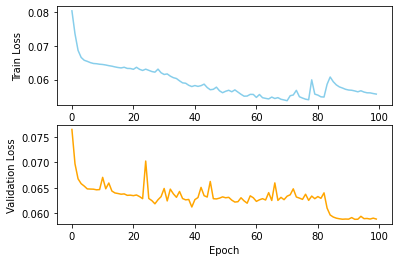

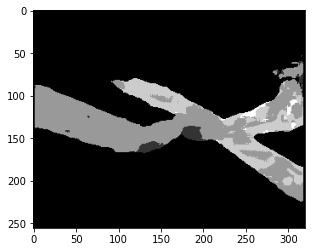

In [ ]:
print("Start Training...")
train_losses = []
train_epoch = []
val_losses = []
val_epoch = []
test_scores = []
num_epochs = 100
# Epoch Begins
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    model.train()
    for i, (inputs, targets) in enumerate(train_dataloader):
      if torch.cuda.is_available():
        inputs = inputs.cuda()
        targets = targets.cuda()
      if i == 0:
        inputs1 = inputs
        targets1 = targets
      outputs = model(inputs)
      train_loss = criterion(model(inputs), targets)
      train_losses.append(train_loss.item())
      train_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    train_loss_avg = np.mean(train_losses[-90:])
    train_epoch.append(train_loss_avg)
    print("train loss:", train_loss_avg)
    # scheduler.step()
    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    for i, (inputs, targets) in enumerate(validation_dataloader):
      if torch.cuda.is_available():
        torch.cuda.empty_cache()
        inputs = inputs.cuda()
        targets = targets.cuda()
      outputs = model(inputs)
      val_loss = criterion(model(inputs), targets)
      val_losses.append(val_loss.item())
    val_loss_avg = np.mean(val_losses[-5:])
    val_epoch.append(val_loss_avg)
    print("val loss:", val_loss_avg)
# Epoch Ends
print("\nTraining Finished.")
########################### Testing #####################################
if torch.cuda.is_available():
  torch.cuda.empty_cache()
test_scores.append(dice_score_dataset(model, test_dataloader, n_classes, True))
print("test score:", test_scores[-1])
########################### Plotting #####################################
# Plot train/val loss w.r.t. epoch
plt.subplot(211)
plt.plot(train_epoch, 'skyblue')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.subplot(212)
plt.plot(val_epoch, 'orange')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()

# Plotting one image as an example
torch.cuda.empty_cache()
outputs1 = model(inputs1)
preds1 = torch.argmax(outputs1, dim=1)
pic = 32 * preds1[0] / 255
pic = pic.cpu()
pic = pic.numpy()
# print(pic.shape)
plt.imshow(pic, cmap=plt.cm.gray)
plt.show()


EPOCH 101 of 100



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train loss: 0.05552851085840356
val loss: 0.05886796998591302

EPOCH 102 of 100

train loss: 0.055549281558070145
val loss: 0.059476778022574714

EPOCH 103 of 100

train loss: 0.05544637881490447
val loss: 0.0593455134700376

EPOCH 104 of 100

train loss: 0.05632082625570112
val loss: 0.06124954294744437

EPOCH 105 of 100

train loss: 0.05639242900423884
val loss: 0.059900668296266425

EPOCH 106 of 100

train loss: 0.055434294729346106
val loss: 0.06009298837537759

EPOCH 107 of 100

train loss: 0.055319988586780104
val loss: 0.06068426126137135

EPOCH 108 of 100

train loss: 0.05524823108422959
val loss: 0.06144205019525282

EPOCH 109 of 100

train loss: 0.055231280046438194
val loss: 0.061374177432879526

EPOCH 110 of 100

train loss: 0.055235231318848964
val loss: 0.061683586354786824

EPOCH 111 of 100

train loss: 0.0550773462513499
val loss: 0.061379878701852755

EPOCH 112 of 100

train loss: 0.0563877467376516
val loss: 0.06387630829468559

EPOCH 113 of 100

train loss: 0.0499769

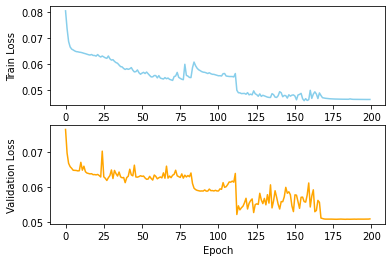

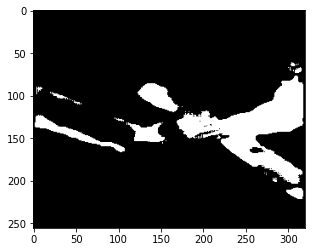

In [ ]:
for epoch in range(100, num_epochs + 100):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    model.train()
    for i, (inputs, targets) in enumerate(train_dataloader):
      if torch.cuda.is_available():
        inputs = inputs.cuda()
        targets = targets.cuda()
      if i == 0:
        inputs1 = inputs
        targets1 = targets
      outputs = model(inputs)
      train_loss = criterion(model(inputs), targets)
      train_losses.append(train_loss.item())
      train_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    train_loss_avg = np.mean(train_losses[-90:])
    train_epoch.append(train_loss_avg)
    print("train loss:", train_loss_avg)
    # scheduler.step()
    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    for i, (inputs, targets) in enumerate(validation_dataloader):
      if torch.cuda.is_available():
        torch.cuda.empty_cache()
        inputs = inputs.cuda()
        targets = targets.cuda()
      outputs = model(inputs)
      val_loss = criterion(model(inputs), targets)
      val_losses.append(val_loss.item())
    val_loss_avg = np.mean(val_losses[-5:])
    val_epoch.append(val_loss_avg)
    print("val loss:", val_loss_avg)
# Epoch Ends
print("\nTraining Finished.")
########################### Testing #####################################
if torch.cuda.is_available():
  torch.cuda.empty_cache()
test_scores.append(dice_score_dataset(model, test_dataloader, n_classes, True))
print("test score:", test_scores[-1])
########################### Plotting #####################################
# Plot train/val loss w.r.t. epoch
plt.subplot(211)
plt.plot(train_epoch, 'skyblue')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.subplot(212)
plt.plot(val_epoch, 'orange')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()

# Plotting one image as an example
torch.cuda.empty_cache()
outputs1 = model(inputs1)
preds1 = torch.argmax(outputs1, dim=1)
pic = 32 * preds1[0] / 255
pic = pic.cpu()
pic = pic.numpy()
# print(pic.shape)
plt.imshow(pic, cmap=plt.cm.gray)
plt.show()

## (c) Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

In [4]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader

##TODO: Add support for colorization dataset
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 input_dir,
                 op,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        try:
            if self.op == 'train_cor':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'validation_cor':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """
        
        """
        ## Load Image and Parse Properties
        img_name = str(idx) + '_gray.jpg'
        target_name = str(idx) + '_input.jpg'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        target = io.imread(os.path.join(self.data_dir, str(idx), target_name))
        # print(img.shape)
        # print(target.shape)
        h, w = target.shape[0], target.shape[1]
        ## Transform image and mask
        if self.transform:
            img, target = self.img_transform(img, target)
        return img, target

    def img_transform(self,
                      img,
                      mask):
        """
        
        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

In [5]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net for colorization
class UNET_CL(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        # super(UNET, self).__init__(n_classes)
        super(UNET_CL, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(1, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        # From 32 channels to 3 RGB channels...
        self.last = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        out = self.last(conv1m_out)
        return out

In [6]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "/content/gdrive/MyDrive/HW6Q1_data"

## Segmentation + Colorization Paths
colorization_data_dir = f"{data_dir}/colorization/"

model_path = " "
## Initialize your unet
n_classes = 6
model = UNET_CL(n_classes)
if torch.cuda.is_available():
    model.cuda()
criterion = nn.MSELoss()

## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=colorization_data_dir, op="train_cor", transforms=img_transform)
validation_dataset=ImageDataset(input_dir=colorization_data_dir, op="validation_cor", transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
train_losses = []
train_epoch = []
val_losses = []
val_epoch = []
for epoch in range(num_epochs):
  print(len(train_dataloader))
  print(len(validation_dataloader))
  print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
  for i, (imgs, targets) in enumerate(train_dataloader):
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      targets = targets.cuda()
    optimizer.zero_grad()
    # print(imgs.shape)  # torch.Size([10, 1, 256, 320])
    # print(targets.shape)  # torch.Size([10, 3, 256, 320])
    outputs = model(imgs)
    # print(outputs.shape)  # torch.Size([10, 3, 256, 320])
    loss = criterion(outputs, targets)
    train_losses.append(loss.item())
    # print(loss.item())
    loss.backward()
    optimizer.step()
  train_loss_avg = np.mean(train_losses)
  print("Train loss:", train_loss_avg)
  train_epoch.append(train_loss_avg)
  train_losses = []
  for i, (imgs, targets) in enumerate(validation_dataloader):
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      targets = targets.cuda()
    outputs = model(imgs)
    loss = criterion(outputs, targets)
    val_losses.append(loss.item())
  val_loss_avg = np.mean(val_losses)
  print("Val loss:", val_loss_avg)
  val_epoch.append(val_loss_avg)
  val_losses = []


159
5

EPOCH 1 of 200



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss: 0.005153834051745446


FileNotFoundError: ignored

In [ ]:
# Save the model parameters
torch.save(model.state_dict(), model_path)

## (d) Training Procedeure (Segmentation after Colorization)

In [ ]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)
if torch.cuda.is_available():
    model.cuda()
criterion = nn.MSELoss()
# Load the model parameters
save_model = torch.load(model_path)
model_dict = model.state_dict()
state_dict = {k:v for k,v in save_model.items() if k in model_dict.keys()}
# print(state_dict.keys())  # dict_keys(['w', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias'])
model_dict.update(state_dict)
model.load_state_dict(model_dict)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Problem 2: Transfer Learning

### Imports

In [ ]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

## (a) Without Pre-Train

### Data Loading

In [ ]:
# Hyperparameters
learning_rate = 0.01

## Specify Batch Size N
train_batch_size = 100
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True, num_workers=4)

# Initialize the VGG16 model
pre_train = False
model = vgg16(pretrained=pre_train)
# Modify the last layer into (4096 -> 10, # of labels of FashionMNIST)
model.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
if torch.cuda.is_available():
  model.cuda()
print(model)
# Define Loss
criterion = nn.NLLLoss()

# Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Evaluation of Accuracy, Loss, etc.
def evaluate(dataloader, verbose=1):
    correct = 0
    total = 0
    loss_sum = 0
    for i, (images, labels) in enumerate(dataloader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      outputs = nn.functional.log_softmax(model(images), dim=1)
      # Prediction should choose the index of the max element in the outputs as the index
      preds = torch.argmax(outputs, dim=1)
      total += labels.size(0)
      correct += (labels.float() == preds.float()).sum()
    acc = 100.0 * correct / total
    if verbose:
      if dataloader == training_dataloader:
        print('Train Accuracy: %f %%' % acc)
      elif dataloader == test_dataloader:
        print('Test Accuracy: %f %%' % acc)
    return acc

### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

Start Training...

EPOCH 1 of 5



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.5950217247009277
0.3760879933834076
0.43449029326438904
0.5110108852386475
0.5115580558776855
0.5407021641731262
Train Loss:  0.41454000008602937
Test Accuracy: 85.250000 %

EPOCH 2 of 5

0.36385682225227356
0.3495112955570221
0.2174527496099472
0.33559489250183105
0.33473777770996094
0.3770010471343994
Train Loss:  0.3515504028648138
Test Accuracy: 87.180000 %

EPOCH 3 of 5

0.32733315229415894
0.3738248348236084
0.3171166479587555
0.32542404532432556
0.38320982456207275
0.32947295904159546
Train Loss:  0.31489608806868397
Test Accuracy: 88.320000 %

EPOCH 4 of 5

0.2753886878490448
0.17425835132598877
0.3143802881240845
0.2524985074996948
0.17660479247570038
0.5232166051864624
Train Loss:  0.28797629501670596
Test Accuracy: 88.669998 %

EPOCH 5 of 5

0.32673180103302
0.3475910425186157
0.2501552999019623
0.20249108970165253
0.21466323733329773
0.37513163685798645
Train Loss:  0.2680089592933655
Test Accuracy: 88.579994 %
Training Finished.


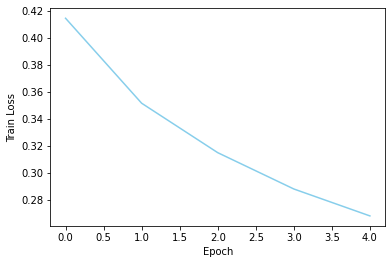

In [ ]:
# print(len(training_dataloader))  # 60000 / N
# print(len(test_dataloader))
print("Start Training...")
train_losses = []
train_epoch = []
num_epochs = 5
# Epoch Begins
for epoch in range(num_epochs):
  ########################### Training #####################################
  print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
  for i, (images, labels) in enumerate(training_dataloader):
    # print(images.shape) # torch.Size([N, 1, 224, 224])
    # print(labels.shape) # torch.Size([N])
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    outputs = nn.functional.log_softmax(model(images), dim=1)
    # print(outputs.shape) # torch.Size([N, 10])
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_losses.append(loss.item())
    if i % 100 == 0:
      print(loss.item())
  train_loss_avg = np.mean(train_losses)
  train_epoch.append(train_loss_avg)
  train_losses = []
  print("Train Loss: ", train_epoch[-1])
  test_acc = evaluate(test_dataloader, verbose=1)
print("Training Finished.")

########################### Plotting #####################################
# Plot train loss w.r.t. epoch
plt.plot(train_epoch, 'skyblue')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

## (b) With Pre-Train

In [ ]:
# Hyperparameters
learning_rate = 0.01

## Specify Batch Size N
train_batch_size = 100
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True, num_workers=4)

# Initialize the VGG16 model
pre_train = True
model = vgg16(pretrained=pre_train)
# Modify the last layer into (4096 -> 10, # of labels of FashionMNIST)
model.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
# Freeze layers
for layer in model.features[1:]:
  # print(layer)
  for param in layer.parameters():
    param.require_grad = False
for layer in model.classifier[:-1]:
  # print(layer)
  for param in layer.parameters():
    param.require_grad = False
if torch.cuda.is_available():
  model.cuda()
print(model)
# Define Loss
criterion = nn.NLLLoss()

# Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Evaluation of Accuracy, Loss, etc.
def evaluate(dataloader, verbose=1):
    correct = 0
    total = 0
    loss_sum = 0
    for i, (images, labels) in enumerate(dataloader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      outputs = nn.functional.log_softmax(model(images), dim=1)
      # Prediction should choose the index of the max element in the outputs as the index
      preds = torch.argmax(outputs, dim=1)
      total += labels.size(0)
      correct += (labels.float() == preds.float()).sum()
    acc = 100.0 * correct / total
    if verbose:
      if dataloader == training_dataloader:
        print('Train Accuracy: %f %%' % acc)
      elif dataloader == test_dataloader:
        print('Test Accuracy: %f %%' % acc)
    return acc

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,

Start Training...

EPOCH 1 of 3



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2.353435516357422
0.898314893245697
0.39124464988708496
0.3752117455005646
0.3976380527019501
0.3276371657848358
Train Loss:  0.5472423245509466
Test Accuracy: 86.869995 %

EPOCH 2 of 3

0.430496484041214
0.3807342052459717
0.29982584714889526
0.22152575850486755
0.2307567000389099
0.24676933884620667
Train Loss:  0.3073859222357472
Test Accuracy: 90.009995 %

EPOCH 3 of 3

0.3226601481437683
0.20137448608875275
0.22277182340621948
0.3535277247428894
0.18616725504398346
0.23711320757865906
Train Loss:  0.2348558734357357
Test Accuracy: 90.699997 %
Training Finished.


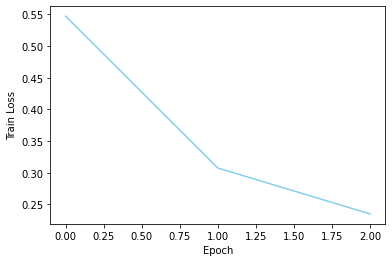

In [ ]:
# print(len(training_dataloader))  # 60000 / N
# print(len(test_dataloader))
print("Start Training...")
train_losses = []
train_epoch = []
num_epochs = 3
# Epoch Begins
for epoch in range(num_epochs):
  ########################### Training #####################################
  print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
  for i, (images, labels) in enumerate(training_dataloader):
    # print(images.shape) # torch.Size([N, 1, 224, 224])
    # print(labels.shape) # torch.Size([N])
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    outputs = nn.functional.log_softmax(model(images), dim=1)
    # print(outputs.shape) # torch.Size([N, 10])
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_losses.append(loss.item())
    if i % 100 == 0:
      print(loss.item())
  train_loss_avg = np.mean(train_losses)
  train_epoch.append(train_loss_avg)
  train_losses = []
  print("Train Loss: ", train_epoch[-1])
  test_acc = evaluate(test_dataloader, verbose=1)
print("Training Finished.")

########################### Plotting #####################################
# Plot train loss w.r.t. epoch
plt.plot(train_epoch, 'skyblue')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

In [ ]:
# print(len(training_dataloader))  # 60000 / N
# print(len(test_dataloader))
print("Start Training...")
train_losses = []
train_epoch = []
num_epochs = 3
# Epoch Begins
for epoch in range(num_epochs):
  ########################### Training #####################################
  print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
  for i, (images, labels) in enumerate(training_dataloader):
    # print(images.shape) # torch.Size([N, 1, 224, 224])
    # print(labels.shape) # torch.Size([N])
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    outputs = nn.functional.log_softmax(model(images), dim=1)
    # print(outputs.shape) # torch.Size([N, 10])
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_losses.append(loss.item())
    if i % 100 == 0:
      print(loss.item())
  train_loss_avg = np.mean(train_losses)
  train_epoch.append(train_loss_avg)
  train_losses = []
  print("Train Loss: ", train_epoch[-1])
  test_acc = evaluate(test_dataloader, verbose=1)
print("Training Finished.")

########################### Plotting #####################################
# Plot train loss w.r.t. epoch
plt.plot(train_epoch, 'skyblue')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

Start Training...

EPOCH 1 of 3



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2.357198715209961
0.601203441619873
0.5083548426628113


KeyboardInterrupt: ignored